In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import community
from pathlib import Path
import glob
import random

from sklearn.metrics import adjusted_rand_score

%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
def subjectmatrix2graphslist(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
    """

    correlation_matrix = pd.read_csv(
        filename,
        header=None
    )
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(
        correlation_matrix.values[tril_idx].flatten(),
        reverse=True
    )

    Gs = []
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))

    return Gs

In [3]:
def extraer_lista_grafos(tipo_red, densities):

    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + "/{}_suj*.csv".format(tipo_red))


    graphs = {}
    for filename in all_files:
        Gs = subjectmatrix2graphslist(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs

    return graphs

In [4]:
densities = np.linspace(0.025,0.15)

G_N1 = extraer_lista_grafos("N1", densities)
G_N2 = extraer_lista_grafos("N2", densities)
G_N3 = extraer_lista_grafos("N3", densities)
G_W = extraer_lista_grafos("W", densities)

In [5]:
densities

array([0.025     , 0.02755102, 0.03010204, 0.03265306, 0.03520408,
       0.0377551 , 0.04030612, 0.04285714, 0.04540816, 0.04795918,
       0.0505102 , 0.05306122, 0.05561224, 0.05816327, 0.06071429,
       0.06326531, 0.06581633, 0.06836735, 0.07091837, 0.07346939,
       0.07602041, 0.07857143, 0.08112245, 0.08367347, 0.08622449,
       0.08877551, 0.09132653, 0.09387755, 0.09642857, 0.09897959,
       0.10153061, 0.10408163, 0.10663265, 0.10918367, 0.11173469,
       0.11428571, 0.11683673, 0.11938776, 0.12193878, 0.1244898 ,
       0.12704082, 0.12959184, 0.13214286, 0.13469388, 0.1372449 ,
       0.13979592, 0.14234694, 0.14489796, 0.14744898, 0.15      ])

In [5]:
def get_modularity(graphs):
    modularity = []
    for name, Gs in graphs.items():
        modularity_ = [community.community_louvain.modularity(community.community_louvain.best_partition(G),G) for G in Gs]
        modularity.append(modularity_)
    modularity = np.vstack(modularity)
    return modularity

In [6]:
def get_number_of_modules(graphs):
    number_of_modules = []
    for name, Gs in graphs.items():
        number_of_modules_ = [
            len(
                set(
                    list(
                        community.community_louvain.best_partition(G).values()
                    )
                )
            ) for G in Gs
        ]
        number_of_modules.append(number_of_modules_)
    number_of_modules = np.vstack(number_of_modules)
    return number_of_modules

In [7]:
N1_modularity = get_modularity(G_N1)
N1_number_of_modules = get_number_of_modules(G_N1)

N2_modularity = get_modularity(G_N2)
N2_number_of_modules = get_number_of_modules(G_N2)

N3_modularity = get_modularity(G_N3)
N3_number_of_modules = get_number_of_modules(G_N3)

W_modularity = get_modularity(G_W)
W_number_of_modules = get_number_of_modules(G_W)


In [8]:
nodes = 116
max_links = (nodes*nodes-nodes)//2

repetitions = 100
random_graphs = {}
for i in range(repetitions):
    Gs = []
    for d in densities:
        G = nx.gnm_random_graph(nodes, max_links * d, seed=i)
        Gs.append(G)
    graphs_ = Gs
    random_graphs[i] = graphs_

random_modularity = get_modularity(random_graphs)
random_number_of_modules = get_number_of_modules(random_graphs)

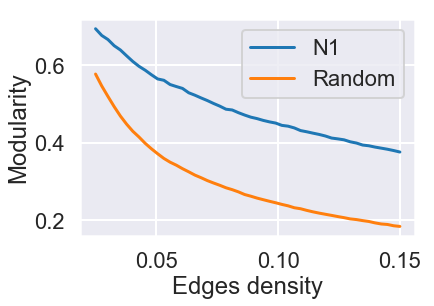

In [34]:
plt.plot(densities, N1_modularity.mean(0), label = "N1")
plt.plot(densities, random_modularity.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Modularity')
plt.legend()
plt.show()

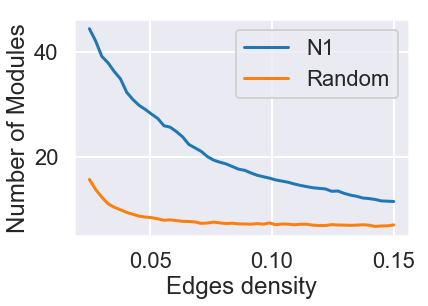

In [33]:
plt.plot(densities, N1_number_of_modules.mean(0), label = "N1")
plt.plot(densities, random_number_of_modules.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Number of Modules')
plt.legend()
plt.show()

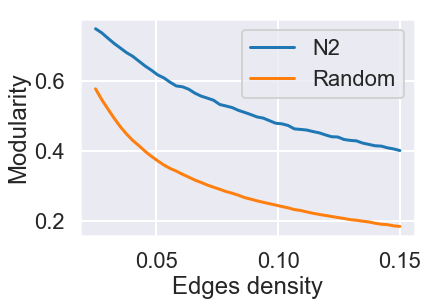

In [32]:
plt.plot(densities, N2_modularity.mean(0), label = "N2")
plt.plot(densities, random_modularity.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Modularity')
plt.legend()
plt.show()

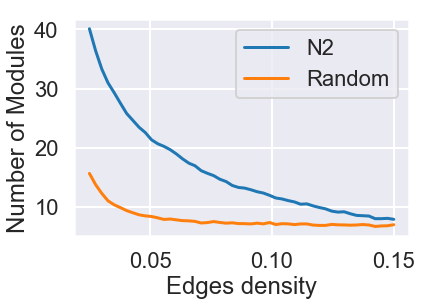

In [31]:
plt.plot(densities, N2_number_of_modules.mean(0), label = "N2")
plt.plot(densities, random_number_of_modules.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Number of Modules')
plt.legend()
plt.show()

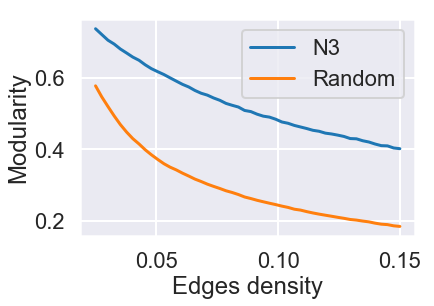

In [30]:
plt.plot(densities, N3_modularity.mean(0), label = "N3")
plt.plot(densities, random_modularity.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Modularity')
plt.legend()
plt.show()

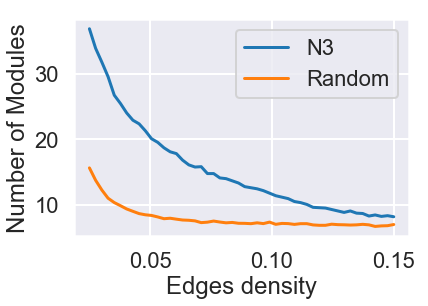

In [29]:
plt.plot(densities, N3_number_of_modules.mean(0), label = "N3")
plt.plot(densities, random_number_of_modules.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Number of Modules')
plt.legend()
plt.show()

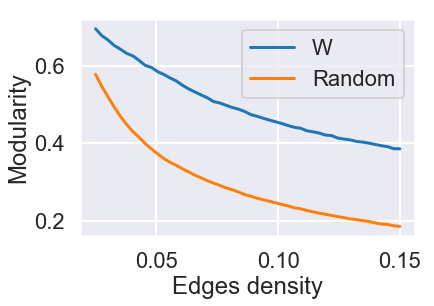

In [28]:
plt.plot(densities, W_modularity.mean(0), label = "W")
plt.plot(densities, random_modularity.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Modularity')
plt.legend()
plt.show()

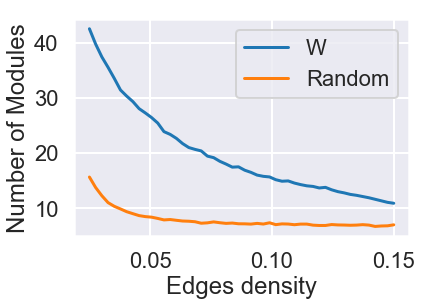

In [27]:
plt.plot(densities, W_number_of_modules.mean(0), label = "W")
plt.plot(densities, random_number_of_modules.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Number of Modules')
plt.legend()
plt.show()

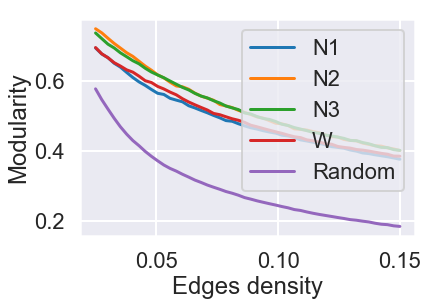

In [25]:
plt.plot(densities, N1_modularity.mean(0), label = "N1")
plt.plot(densities, N2_modularity.mean(0), label = "N2")
plt.plot(densities, N3_modularity.mean(0), label = "N3")
plt.plot(densities, W_modularity.mean(0), label = "W")
plt.plot(densities, random_modularity.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Modularity')
plt.legend()
plt.show()

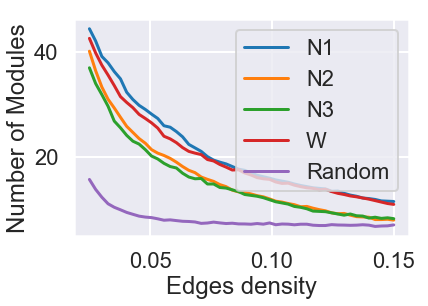

In [26]:
plt.plot(densities, N1_number_of_modules.mean(0), label = "N1")
plt.plot(densities, N2_number_of_modules.mean(0), label = "N2")
plt.plot(densities, N3_number_of_modules.mean(0), label = "N3")
plt.plot(densities, W_number_of_modules.mean(0), label = "W")
plt.plot(densities, random_number_of_modules.mean(0), label = "Random")
plt.xlabel('Edges density')
plt.ylabel('Number of Modules')
plt.legend()
plt.show()